# Domácí úloha 6

### Tomáš Novotný

zdroje: ML2, https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

In [1]:
import random

# datová analytika
import pandas as pd
import numpy as np

# grafy
import matplotlib.pyplot as plt

# dataset
from sklearn.datasets import load_digits

# vyhodnocování a předzpracování
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# neuronové sítě
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split

Načtení datasetu

In [2]:
# načtení datasetu
digits = load_digits()

# vytvoření dataframu
data = pd.DataFrame(digits.data, columns=[f'pixel_{i}' for i in range(digits.data.shape[1])])
target = pd.DataFrame(digits.target, columns=['label'])
df = pd.concat([data, target], axis=1)

In [3]:
TEST_SIZE = 0.15
TRAIN_SIZE = 0.8
RANDOM_SEED = 666
random_generator = torch.Generator().manual_seed(RANDOM_SEED)

In [4]:
# Rozdělení datasetu na vysvětlovaný příznak a zbylá data
X = df.drop("label", axis=1)
y = df["label"]

In [5]:
DATA_DIM = len(X.values[0]) # počet dat
CLASS_COUNT = len(target['label'].unique()) # počet tříd

Převod na dataset tenzorů a rozdělení datasetu na trénovací a validační.

In [6]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, train_size=1-TEST_SIZE, random_state=RANDOM_SEED)

print(f"Počet dat v trénovací množině: {X_Train.shape[0]} ({int((1-TEST_SIZE) * 100)} %)")
print(f"Počet dat v testovací množině: {X_Test.shape[0]} ({int((TEST_SIZE) * 100)} %)")

Počet dat v trénovací množině: 1527 (85 %)
Počet dat v testovací množině: 270 (15 %)


Převod množin na tenzory a rozdělení na trénovací, validační a testovací množiny dat.

In [7]:
# výsledné tensory budou mít rozměry 1 x 32 x 32, kde 32 x 32 je rozměr obrázku a 1 reprezentuje počet barevných kanálů
X_Train_tensor = torch.from_numpy(X_Train.values.reshape(-1, 1, 8, 8).astype('float32'))
y_Train_tensor = torch.tensor(y_Train.values, dtype = torch.long)

X_Test_tensor = torch.from_numpy(X_Test.values.reshape(-1, 1, 8, 8).astype('float32'))
y_Test_tensor = torch.tensor(y_Test.values, dtype = torch.long)

# převod na tensor dataset
dataset = TensorDataset(X_Train_tensor, y_Train_tensor)
test_dataset = TensorDataset(X_Test_tensor, y_Test_tensor)

# rozdělení na trénovací a validační data
train_data, val_data = random_split(dataset, [TRAIN_SIZE, 1 - TRAIN_SIZE], random_generator)

*Funkce trénující model přes jednu epochu a vyhodnocující model na trénovací množině.*

In [8]:
def train_one_epoch(model, optimizer, loss_fn, training_loader):
    running_cum_loss = 0. # kumulativní chyba
    correct = 0 # počet správně klasifikovaných

    for inputs, labels in training_loader:
        # Vynulování gradientu v každé dávce
        optimizer.zero_grad()

        # Dopředný průchod sítí
        outputs = model(inputs)

        # Výpočet hodnoty účelové funkce
        loss = loss_fn(outputs, labels)
        
        # Zpětné šíření chyby přes gradient
        loss.backward()

        # Aktualizace vah
        optimizer.step()

        # Sběr výsledků
        running_cum_loss += loss.item() * inputs.shape[0]
        correct += (outputs.argmax(1) == labels).sum()

    # průměrná hodnota účelové funkce na celém trénovacím datasetu
    return running_cum_loss / len(train_data), correct * 100 / len(train_data)

*Funkce počítající kumulativní chybu a přesnost na validační množině.*

In [9]:
def validate_model(model, loss_fn, validation_loader):
    running_cum_vloss = 0.0
    vcorrect = 0

    with torch.no_grad(): # výpočet bez gradientu
        for vinputs, vlabels in validation_loader:
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)

            # Spočítání kumulativní chyby a správně klasifikovaných
            running_cum_vloss += vloss.item() * vinputs.shape[0]
            vcorrect += (voutputs.argmax(1) == vlabels).sum()

    # Průměrná kumulativní ztráta a přesnost
    return running_cum_vloss / len(val_data), vcorrect * 100 / len(val_data)

*Třída zajišťující regularizační metodu Early Stopping.*

In [10]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.early_stop = False
        self.patience = patience
        self.best_loss = None
        self.not_improved = 0

    def __call__(self, vloss, model = None):
        if self.best_loss is None or self.best_loss > vloss:
            self.best_loss = vloss
            self.not_improved = 0
        else:
            self.not_improved += 1
            if self.not_improved >= self.patience:
                return True
            
        return False

*Funkce zajišťující trénování modelu a sběr hodnocení modelu v epochách.*

In [11]:
def train(model, optimizer, loss_fn, training_loader, validation_loader, patience, epochs):
    # inicializace polí pro sběr výsledků trénování
    losses = []
    accs = []
    vlosses = []
    vaccs = []

    # zavedení early stoppingu
    early_stopping = EarlyStopping(patience)

    for _ in range(epochs):
        model.train() # indikace trénování (např. pro dropout vrstvu)
        loss, acc = train_one_epoch(model, optimizer, loss_fn, training_loader)
        model.eval() # indikace validace
        vloss, vacc = validate_model(model, loss_fn, validation_loader)

        if early_stopping(vloss, model): # předčasné ukončení
            break

        # uložení výsledků pro danou epochu
        losses.append(loss)
        accs.append(acc)
        vlosses.append(vloss)
        vaccs.append(vacc)

    return losses, accs, vlosses, vaccs

*Funkce na vizualizaci výsledků trénování modelu v jednotlivých epochách při daných hyperparametrech.*

In [12]:
POINT_SIZE = 8
def plot_result(losses, accs, vlosses, vaccs):
    print(f"Nejlepší výsledek na validační množině (epocha={np.argmax(vaccs)+1}):\n  Ztrátová funkce={max(vlosses):.5f}, Přesnost={max(vaccs):.2f}%")
    if max(vaccs) > 99.5:
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
        fig.suptitle("Výsledky trénování - kumulativní chyba a přesnost predikce")
        ax[0].set_xlabel("Epocha")
        ax[0].set_ylabel("Kumulativní chyba")
        ax[0].scatter(range(1, len(losses)+1), losses, c='blue', label="Trénovací", s = POINT_SIZE)
        ax[0].scatter(range(1, len(vlosses)+1), vlosses, c='red', label="Validační", s = POINT_SIZE)
        ax[0].legend()

        ax[1].set_xlabel("Epocha")
        ax[1].set_ylabel("Přesnost")
        ax[1].scatter(range(1, len(accs)+1), accs, c='blue', label="Trénovací", s = POINT_SIZE)
        ax[1].scatter(range(1, len(vaccs)+1), vaccs, c='red', label="Validační", s = POINT_SIZE)
        ax[1].plot([1, len(vaccs)+1], [max(vaccs), max(vaccs)],'g--', label="Nejvyšší přesnost na validační množině")
        ax[1].legend()
        plt.show()
    print()

*Funkce inicializující model konvoluční neuronové sítě, optimalizační metodu a dávkovače dat pro trénování.*

In [13]:
def init_model_cnn(hidden, dropout_prob, opt_method, learning_rate, L2_reg, batch_size, batch_norm):
    # inicializace modelu
    model = CNNNeuralNetwork(hidden, dropout_prob, batch_norm)

    # inicializace optimalizační metody
    optimizer = opt_method(model.parameters(), lr=learning_rate, weight_decay=L2_reg) # weight_decay ovlivňuje regularizaci L2 normy vah

    # inicializace dávkovačů trénovacích a validačních dat
    training_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # parametr shuffle zamíchá dávku
    validation_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return model, optimizer, training_loader, validation_loader

Nyní vytvoříme třídu modelu konvoluční neuronové sítě.

Návrh je složený z dvou podobných vrstev vypadajících takto:
* Konvoluční vrstva rozšiřující kanály z jednoho na 32 a jádrem 3x3. Je přidán padding, který vrátí původní rozměry datasetu.
* Dávková normalizace - zmírňuje problémy hlubokých sítí, vhodná při obrázkových datech, aplikovaná před aktivační funkcí.
* Aktivační funkce - nelineární vrstva.
* Polling vrstva - redukuje rozměry výstupu, vylepšuje invarianci vůči malým posunutím.

Po této konvoluční části následuje plně propojená část, kde se při postupné redukci výstupů přes lineární vrstvy aplikuje také dropout vrstva.

In [14]:
class CNNNeuralNetwork(nn.Module):
    def __init__(self, hidden, dropout_prob = 0, batch_norm = False):
        super(CNNNeuralNetwork, self).__init__()
        if batch_norm:
            self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1), # zachování rozměrů (vlivem paddingu), zvýšení počtu kanálů na 32 (32 x 32 x 32)
            nn.BatchNorm2d(32), # dávková normalizace výstupních kanálů
            hidden, # aktivační funkce po aplikaci konvoluční vrstvy
            nn.MaxPool2d(kernel_size = 2, stride = 2) # snížení rozlišení obrázku na polovinu (32 x 16 x 16) - vlivem posuvu indexů (downsampling)
            )
            self.layer2 = nn.Sequential(
                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), # zvýšení počtu kanálů na 64 a snížení velikosti obrázku o 2 (64 x 14 x 14)
                nn.BatchNorm2d(64), # dávková normalizace výstupních kanálů
                hidden, # aktivační funkce po aplikaci konvoluční vrstvy
                nn.MaxPool2d(kernel_size = 2, stride = 2) # opět snížení rozlišení obrázku na polovinu (64 x 7 x 7)
            )
        else: # bez dávkové normalizace
            self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1), # zachování rozměrů (vlivem paddingu), zvýšení počtu kanálů na 32 (32 x 32 x 32)
            hidden, # aktivační funkce po aplikaci konvoluční vrstvy
            nn.MaxPool2d(kernel_size = 2, stride = 2) # snížení rozlišení obrázku na polovinu (32 x 16 x 16) - vlivem posuvu indexů (downsampling)
            )
            self.layer2 = nn.Sequential(
                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), # zvýšení počtu kanálů na 64 a zachování předchozích rozměrů
                hidden, # aktivační funkce po aplikaci konvoluční vrstvy
                nn.MaxPool2d(kernel_size = 2, stride = 2) # opět snížení rozlišení obrázku na polovinu (64 x 8 x 8)
            )

        self.fc1 = nn.Linear(in_features = 64 * 2 * 2, out_features = 512) # aplikace lineární vrstvy s 512 výstupy
        self.dropout = nn.Dropout(dropout_prob) # náhodné vynulování vstupů 
        self.fc2 = nn.Linear(in_features = 512, out_features = 128) # aplikace lineární vrstvy snižující počet výstupů na 128
        self.fc3 = nn.Linear(in_features = 128, out_features = CLASS_COUNT) # konečná lineární vrstva snižující počet výstupů na počet tříd

    def forward(self, x):
        x = self.layer1(x) # první konvoluční vrstva
        x = self.layer2(x) # druhá konvoluční vrstva
        x = x.flatten(start_dim = 1) # příprava rozměru dat na plně propojenou vrstvu
        # lineární vrstvy
        x = self.fc1(x)
        if self.training:
            x = self.dropout(x) # náhodné vynulování výstupů
        x = self.fc2(x)
        x = self.fc3(x)
        return x

Parametry trénování

In [15]:
LOSS_FN = nn.CrossEntropyLoss() # účelová funkce
LEARNING_RATE = 0.001 # statický parametr optimalizační metody SGD

DROPOUT_PROBS = [0, 0.3]

OPTIMIZERS = [optim.Adam] # optimalizační metody gradientního sestupu
HIDDENS = [nn.ReLU(), nn.LeakyReLU()] # aktivační funkce skrytých vrstev
BATCH_SIZES = [16, 32, 64] # velikost dávky při trénování
L2_REGS = [0, 0.001] # L2 regularizace
EARLY_STOPPING_PATIENCE = [4] # velikost tolerované sekvence zhoršování modelu
EPOCHS = 25 # maximální počet epoch

V následující buňce spustím trénování přes různé kombinace parametrů.

V logu se navíc vykreslí i křivka úspěšnosti na trénovacích a validačních datech pro validační přesnost > 99.5%.

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.98325, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.13591, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.22667, Přesnost=98.36%

Optimalizační metoda: <class 'torch.op

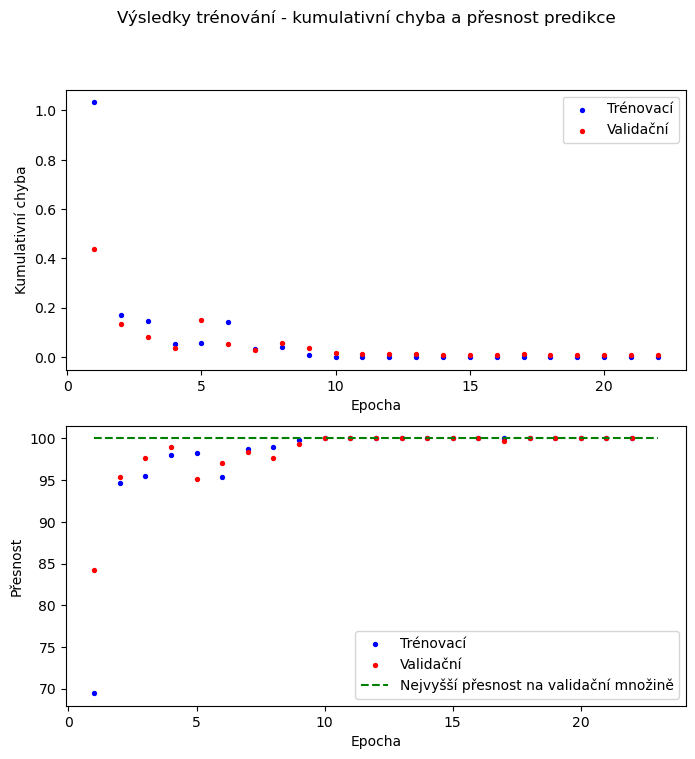


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=3):
  Ztrátová funkce=0.20741, Přesnost=98.69%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=14):
  Ztrátová funkce=0.37650, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=11):
  Ztrátová funkce=0.32706, Přesnost=99.67%


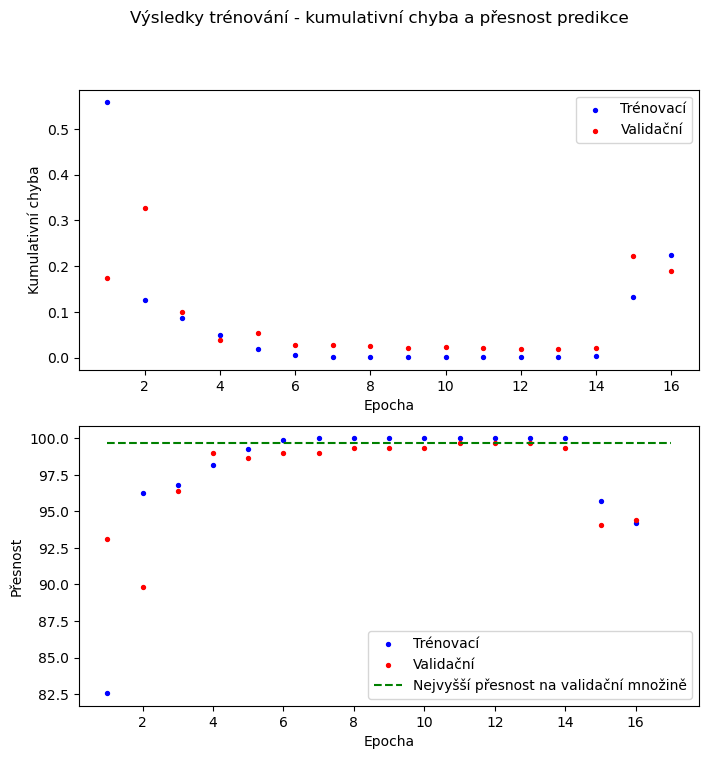


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.30911, Přesnost=99.67%


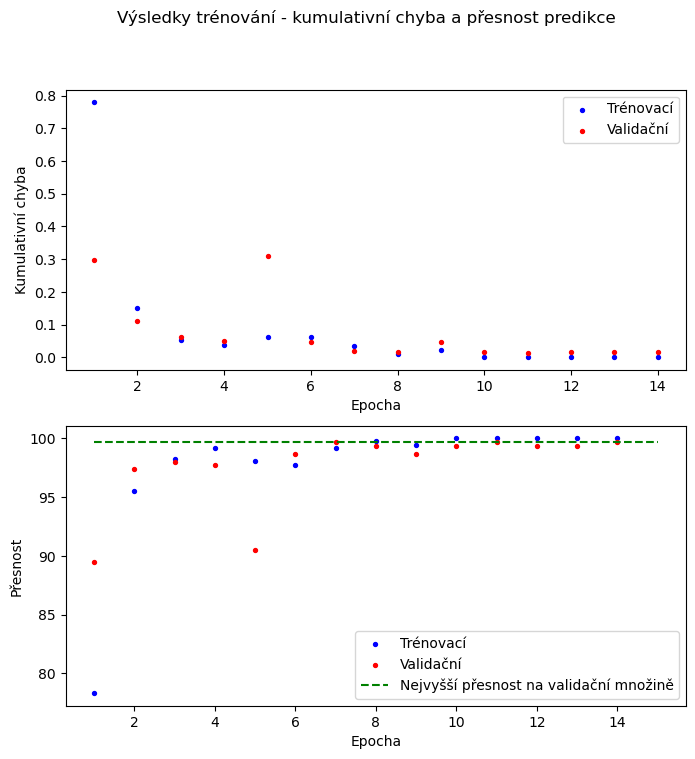


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=11):
  Ztrátová funkce=0.28359, Přesnost=100.00%


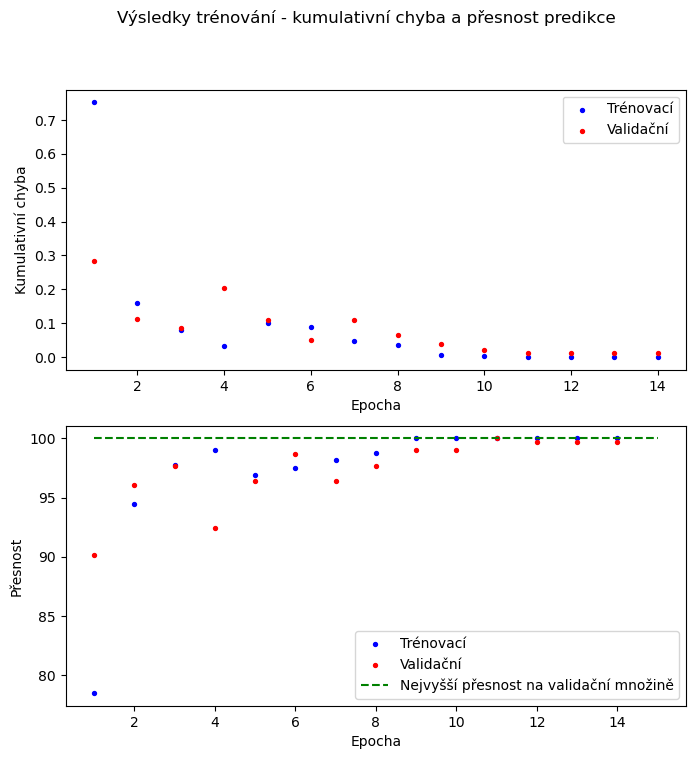


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=16):
  Ztrátová funkce=0.18395, Přesnost=99.67%


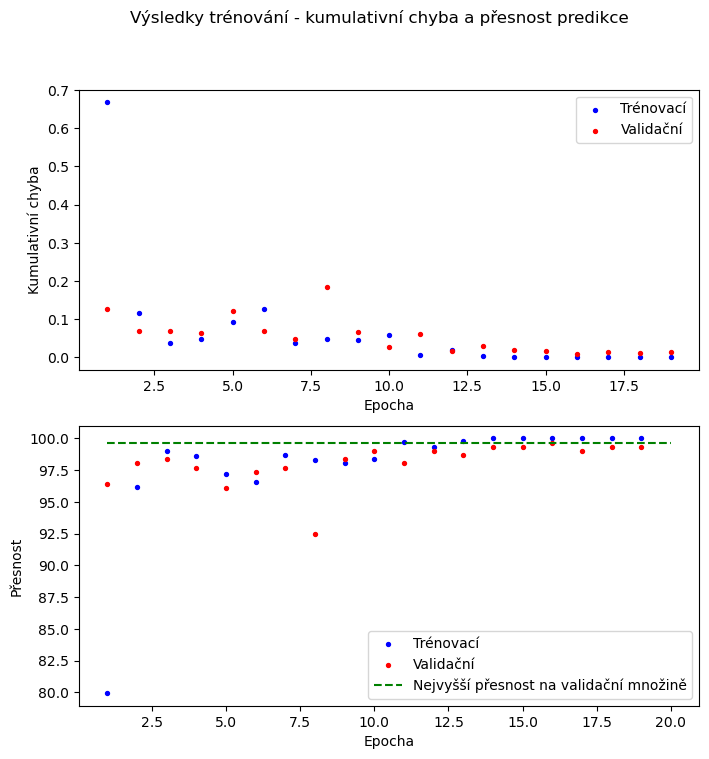


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=9):
  Ztrátová funkce=0.18504, Přesnost=100.00%


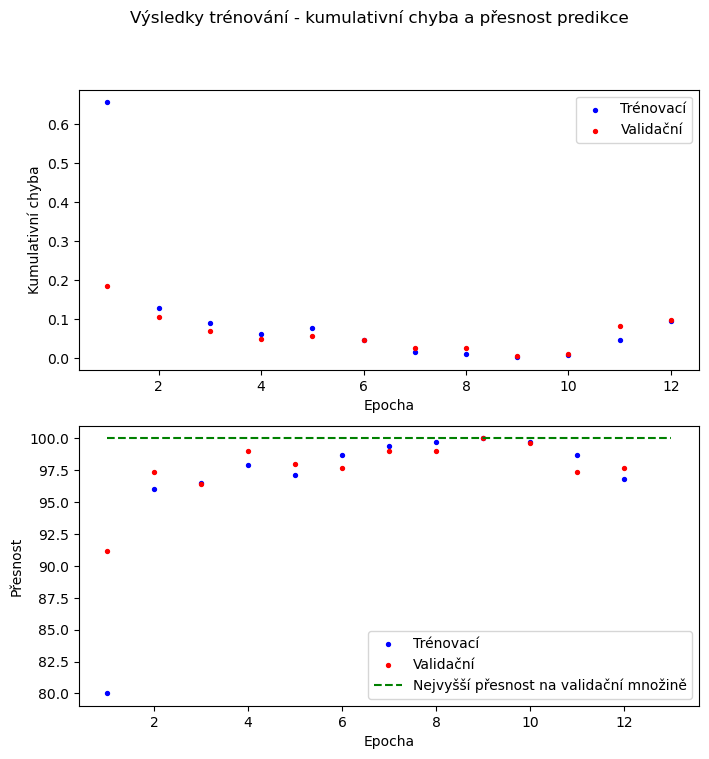


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=5):
  Ztrátová funkce=0.24163, Přesnost=98.69%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 16
Nejlepší výsledek na validační množině (epocha=4):
  Ztrátová funkce=0.21578, Přesnost=99.02%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=5):
  Ztrátová funkce=0.15226, Přesnost=99.67%


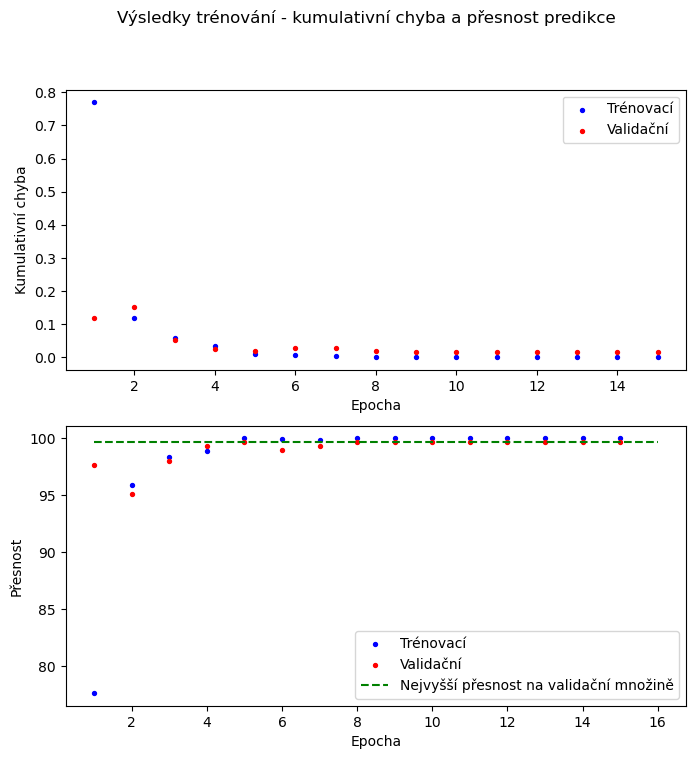


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=9):
  Ztrátová funkce=0.23656, Přesnost=99.67%


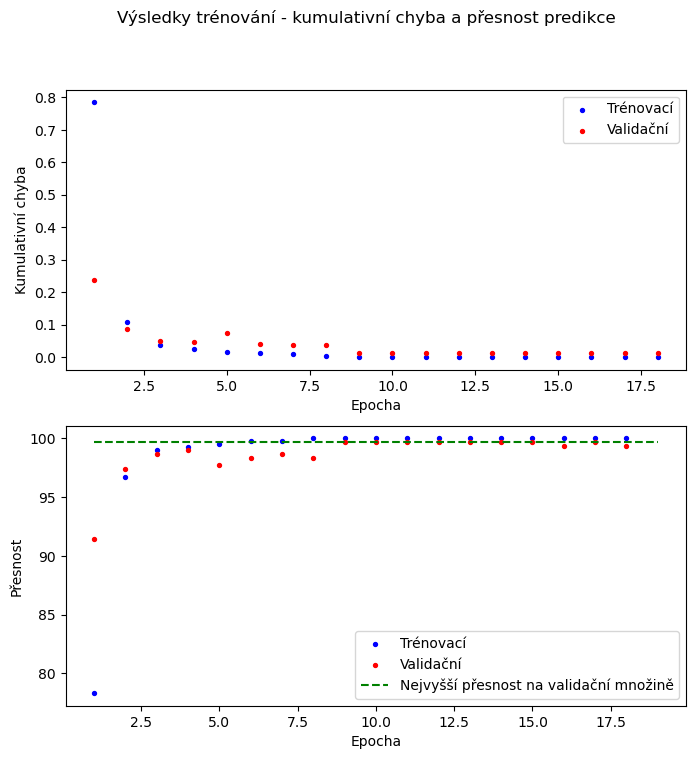


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.38946, Přesnost=99.67%


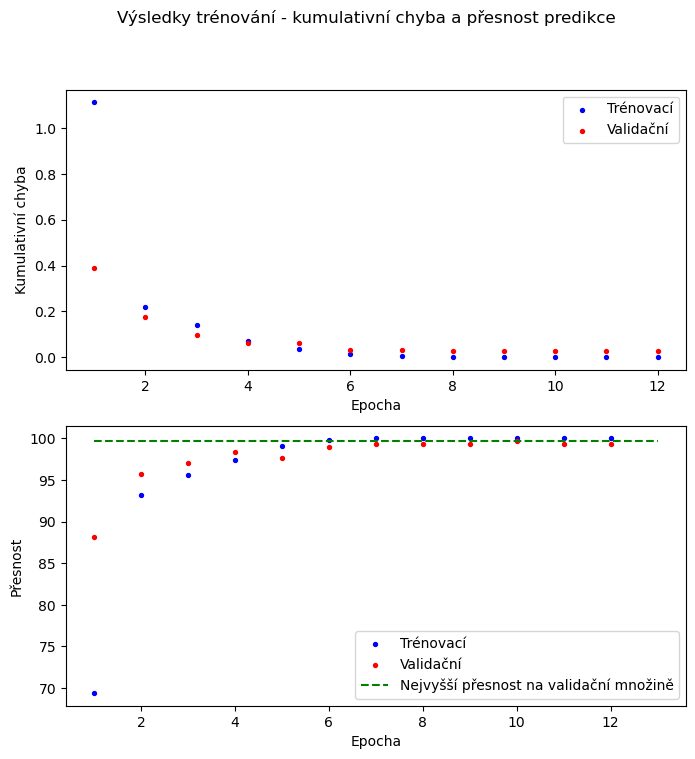


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.24395, Přesnost=99.67%


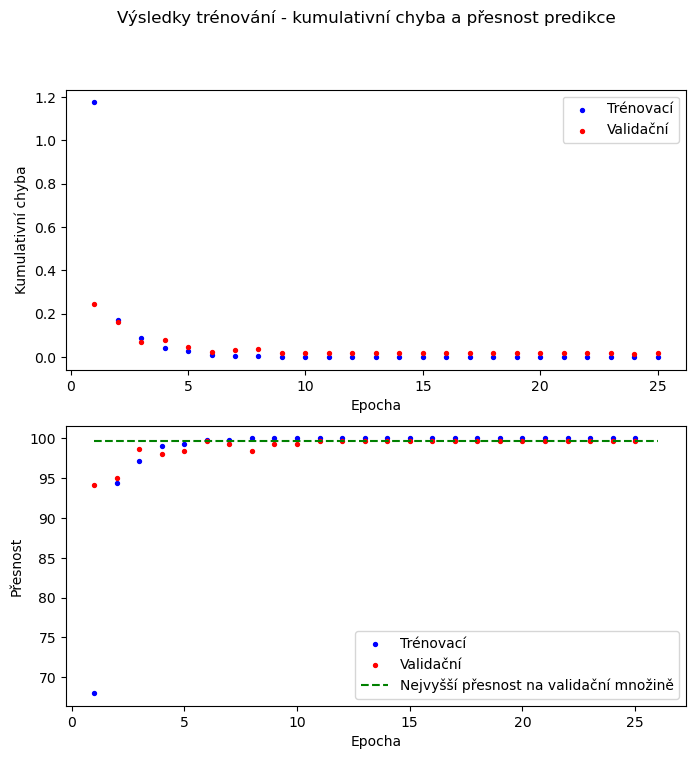


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=4):
  Ztrátová funkce=0.20720, Přesnost=99.67%


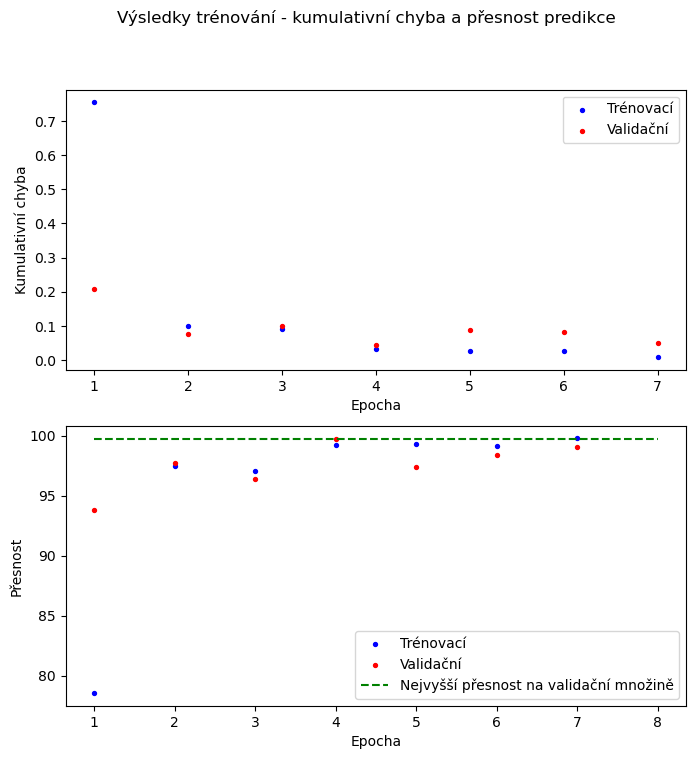


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=5):
  Ztrátová funkce=0.19940, Přesnost=99.67%


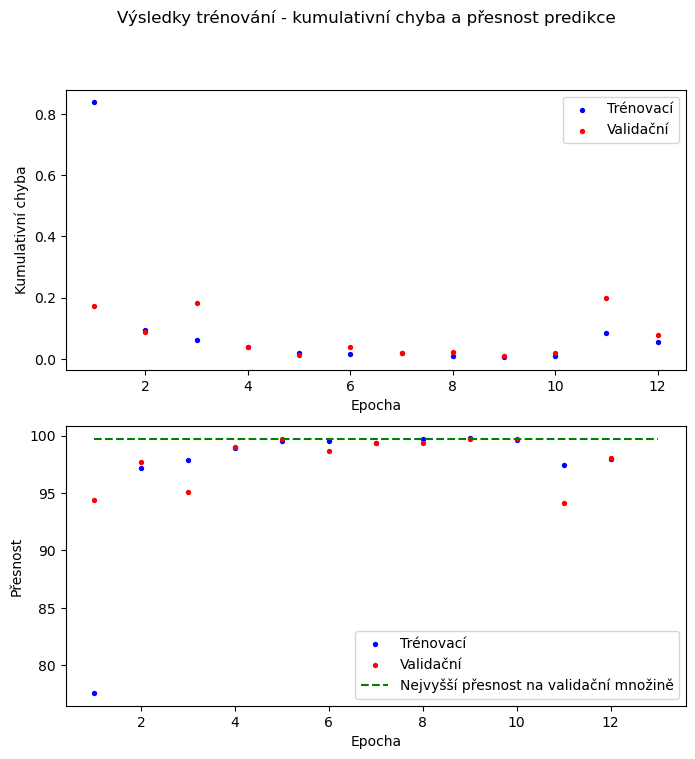


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.31932, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=11):
  Ztrátová funkce=0.22252, Přesnost=100.00%


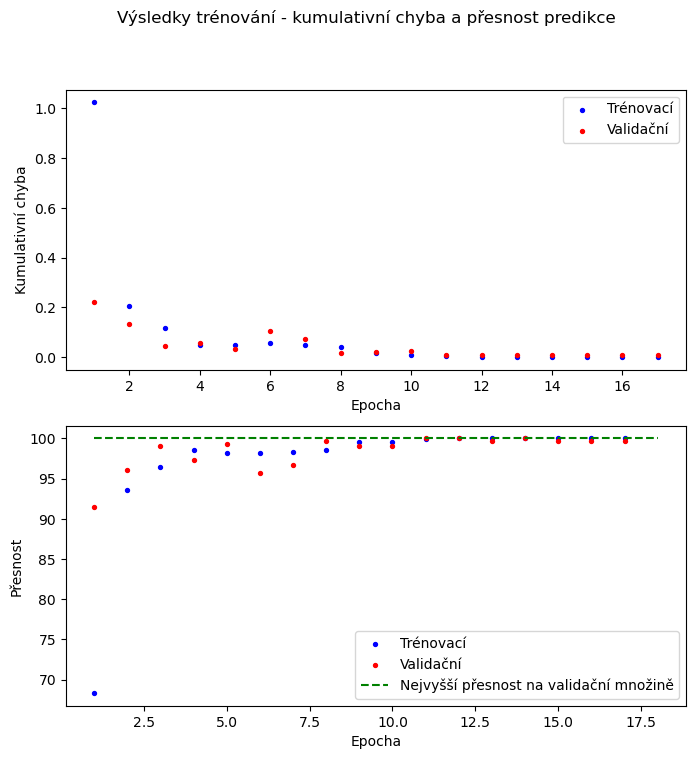


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=13):
  Ztrátová funkce=0.12523, Přesnost=99.67%


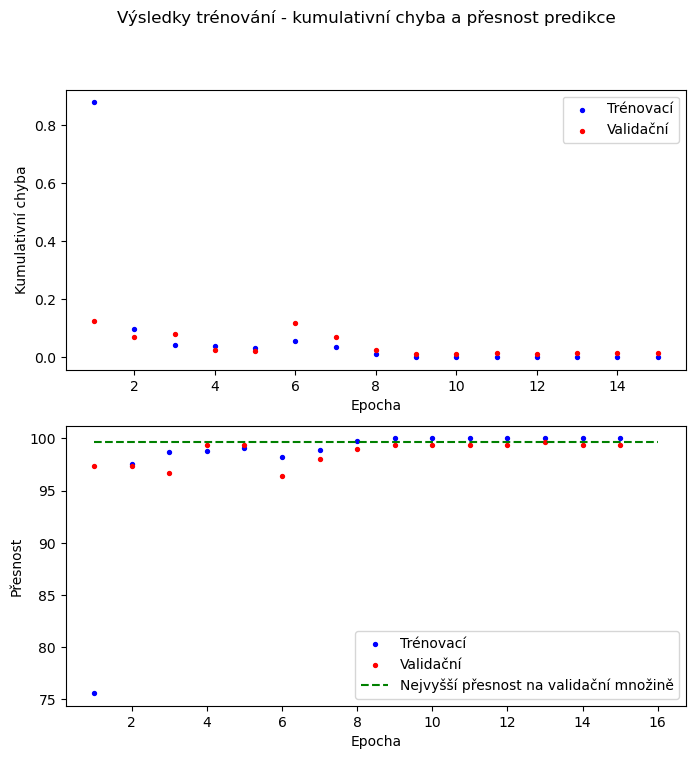


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.19742, Přesnost=100.00%


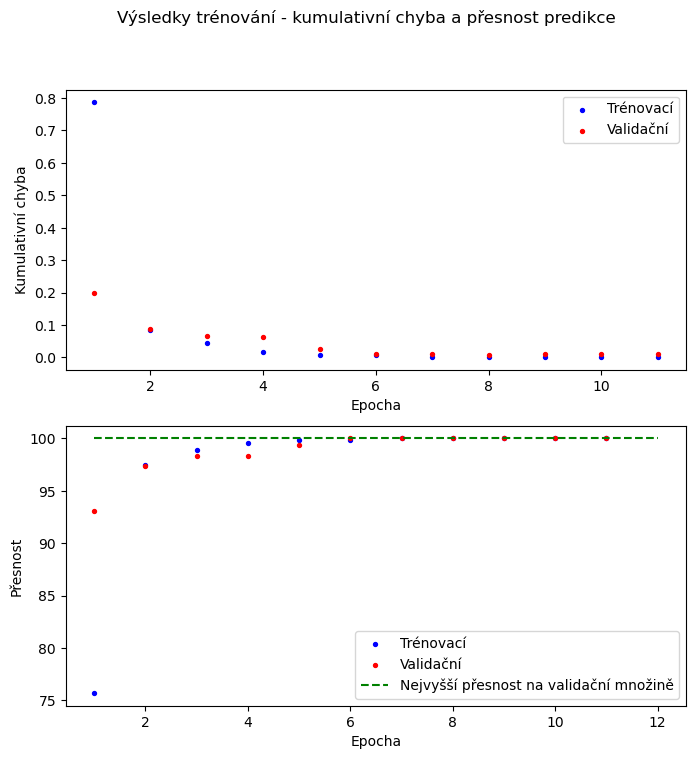


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=7):
  Ztrátová funkce=0.43364, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=5):
  Ztrátová funkce=0.23397, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.17245, Přesnost=99.34%

Optimalizační metoda: <

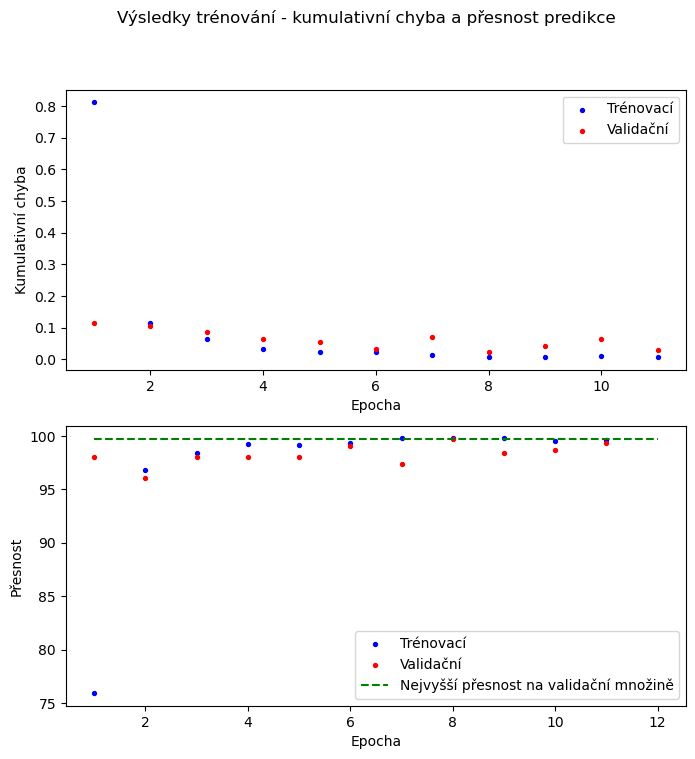


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.30069, Přesnost=99.67%


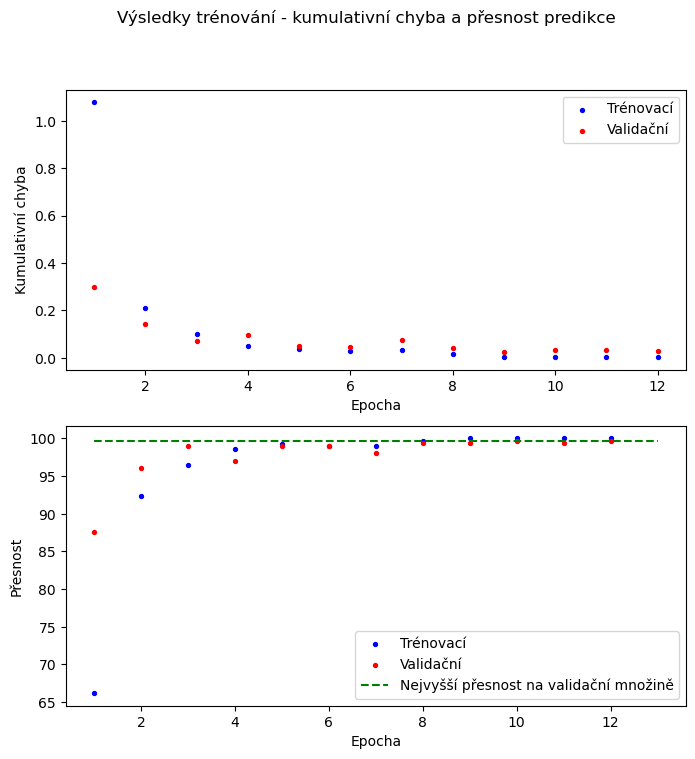


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 32
Nejlepší výsledek na validační množině (epocha=15):
  Ztrátová funkce=0.46540, Přesnost=99.67%


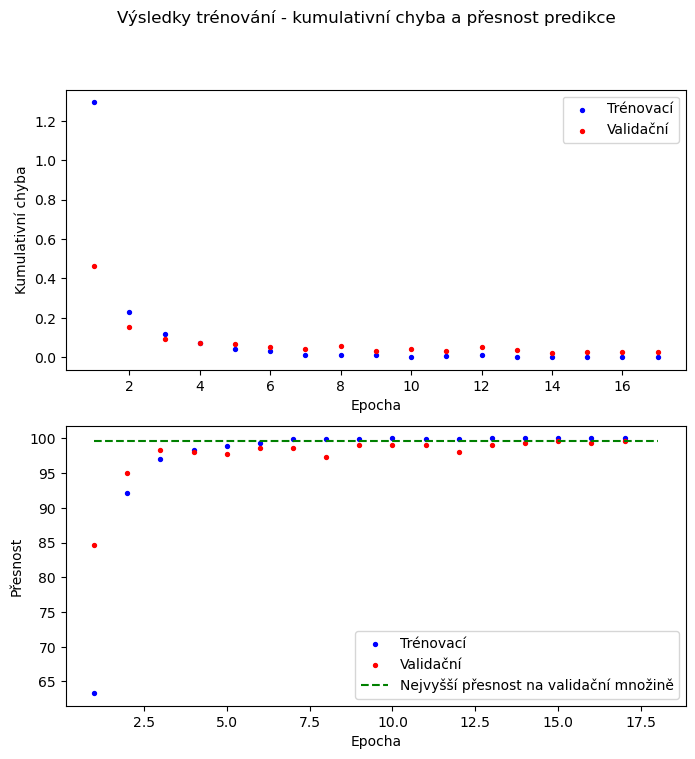


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=5):
  Ztrátová funkce=0.47211, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.37329, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.43568, Přesnost=100.00%


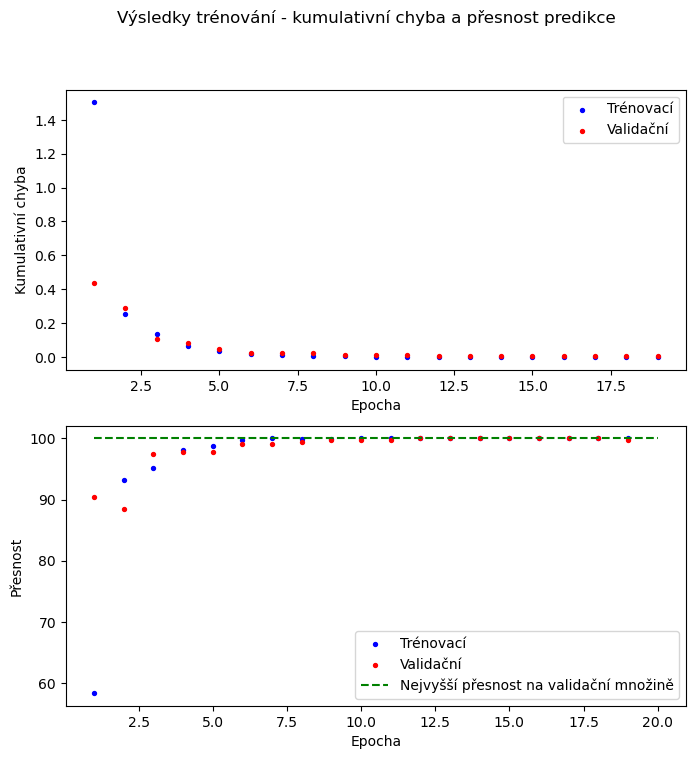


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.62816, Přesnost=99.67%


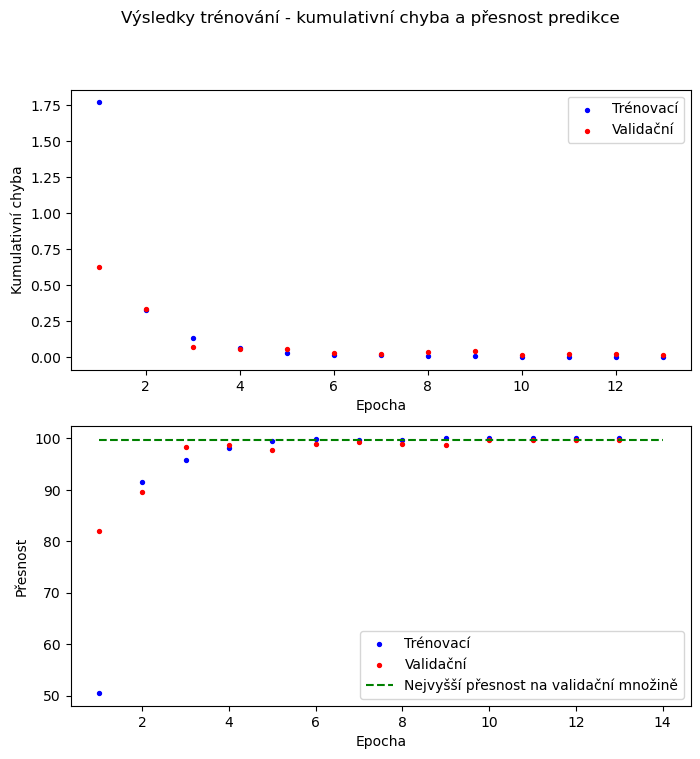


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=8):
  Ztrátová funkce=0.33637, Přesnost=99.67%


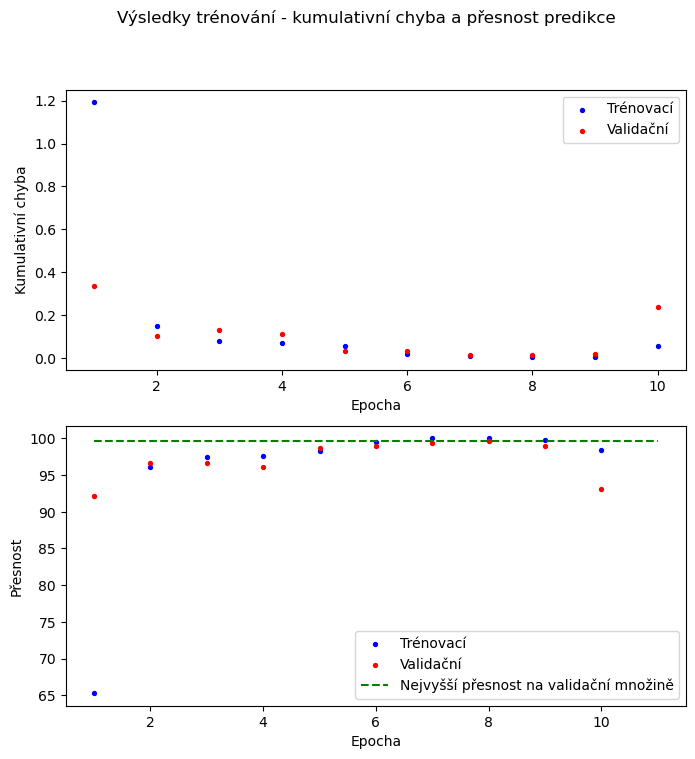


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=10):
  Ztrátová funkce=0.34673, Přesnost=100.00%


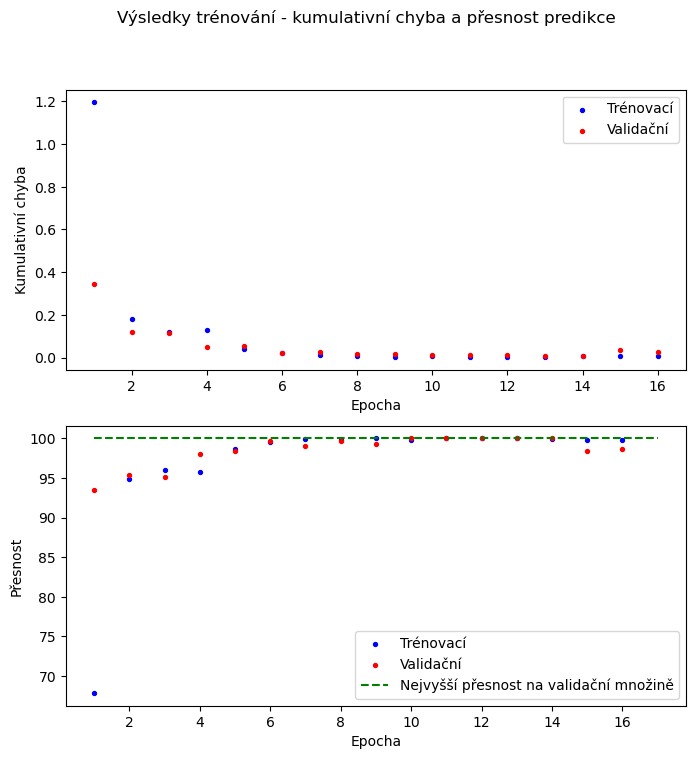


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=9):
  Ztrátová funkce=0.40883, Přesnost=100.00%


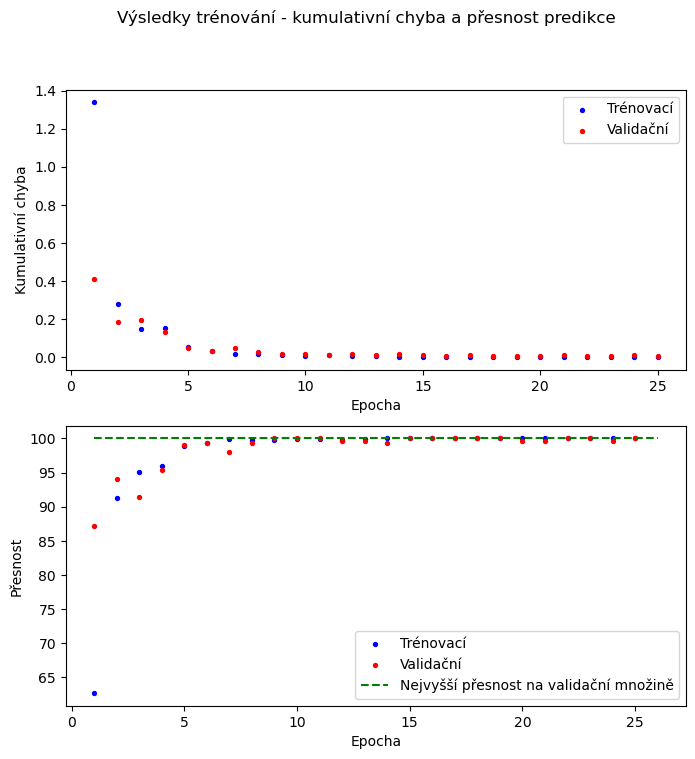


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.45880, Přesnost=100.00%


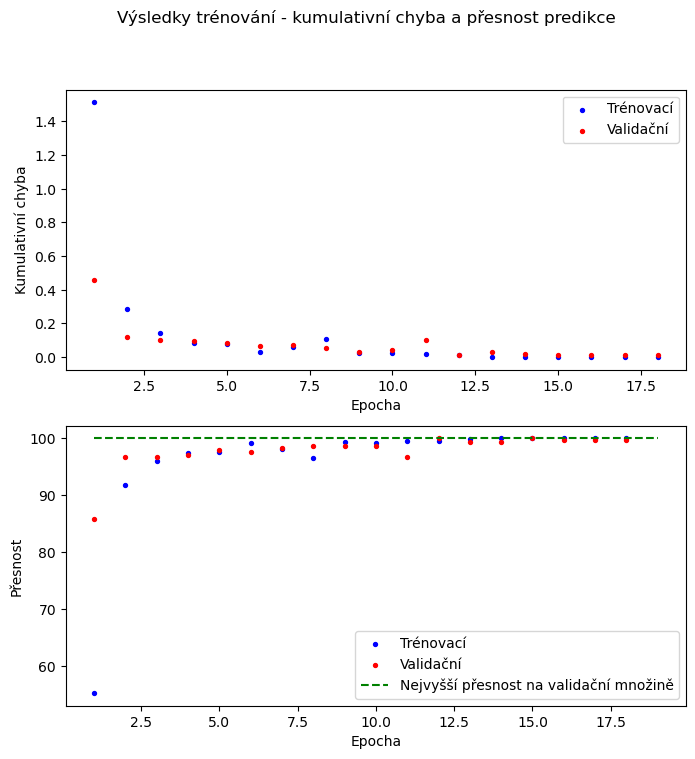


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=20):
  Ztrátová funkce=0.35646, Přesnost=99.67%


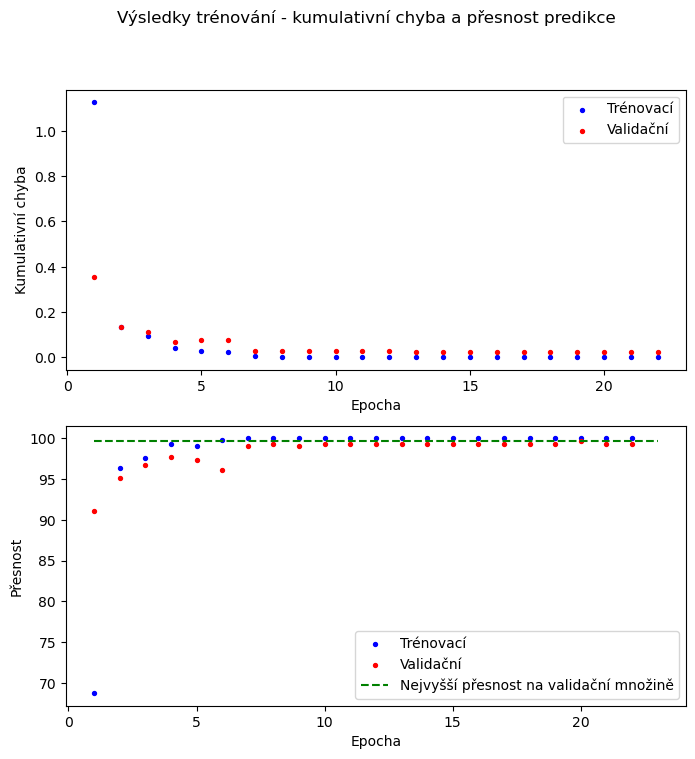


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=4):
  Ztrátová funkce=0.31423, Přesnost=99.67%


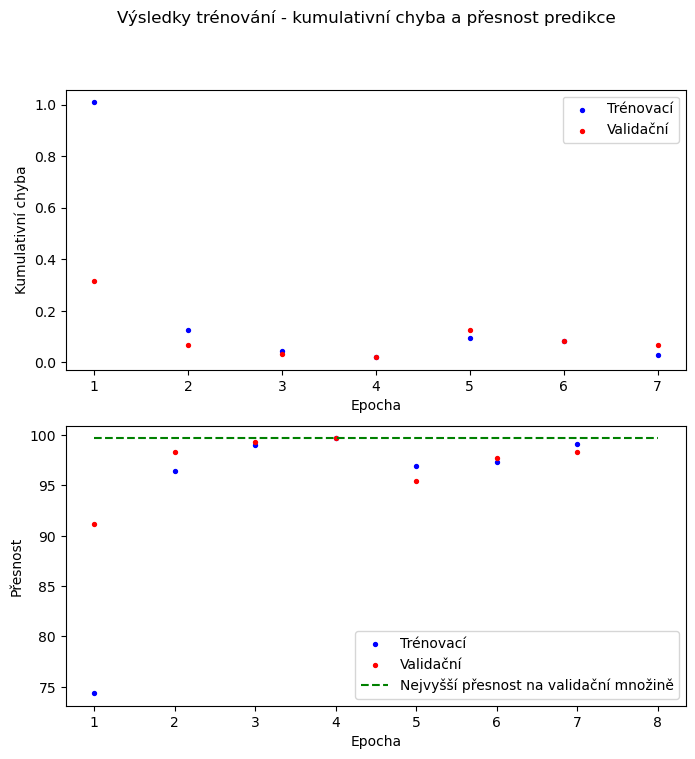


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=12):
  Ztrátová funkce=0.73627, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=11):
  Ztrátová funkce=0.66494, Přesnost=99.34%

Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: True
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=6):
  Ztrátová funkce=0.40253, Přesnost=99.34%

Optimalizační metoda:

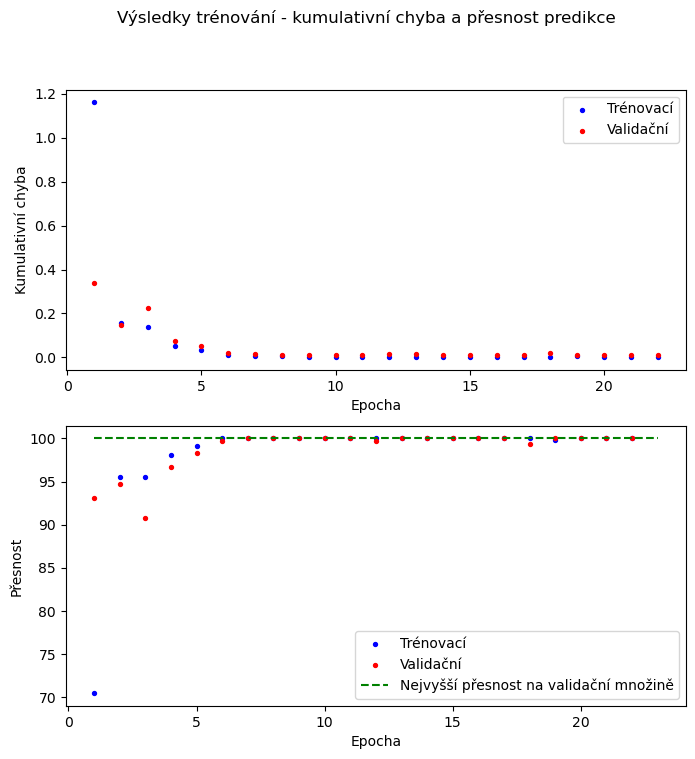


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: ReLU()
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=17):
  Ztrátová funkce=0.61580, Přesnost=99.67%


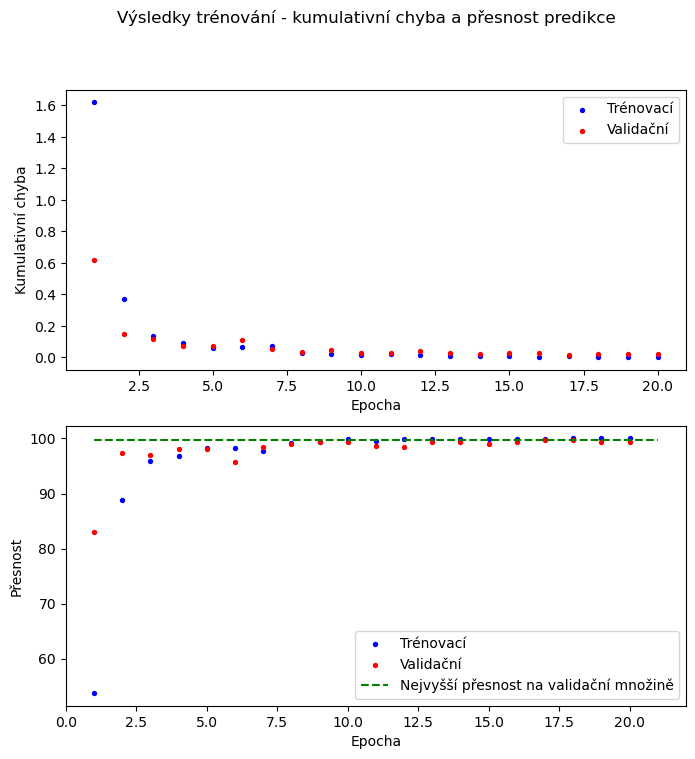


Optimalizační metoda: <class 'torch.optim.adam.Adam'>
Aktivační funkce: LeakyReLU(negative_slope=0.01)
Dávková normalizace: False
Pravděpodobnost vynulování výstupu: 0.3
L2 regularizační člen: 0.001
Parametr časného zastavení: 4
Velikost dávky: 64
Nejlepší výsledek na validační množině (epocha=20):
  Ztrátová funkce=0.54729, Přesnost=100.00%


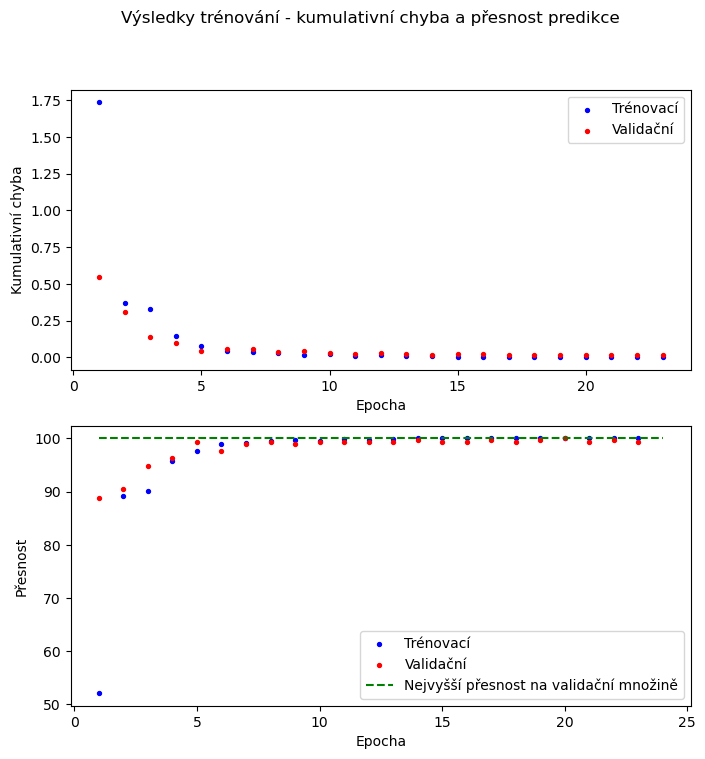

In [16]:
best_acc = None
for patience in EARLY_STOPPING_PATIENCE:
    for batch_size in BATCH_SIZES:
        for L2_reg in L2_REGS:
            for dropout_prob in DROPOUT_PROBS:
                for batch_norm in [True, False]:
                    for hidden in HIDDENS:
                        for opt_method in OPTIMIZERS:
                            # příprava
                            model, optimizer, training_loader, validation_loader = init_model_cnn(hidden, dropout_prob, opt_method, LEARNING_RATE, L2_reg, batch_size, batch_norm)

                            # trénování
                            losses, accs, vlosses, vaccs = train(model, optimizer, LOSS_FN, training_loader, validation_loader, patience, EPOCHS)

                            # získání nejlepšího modelu
                            if not best_acc or np.max(vaccs) > best_acc:
                                final_model = model
                                best_acc = np.max(vaccs)

                            print(f"Optimalizační metoda: {opt_method}")
                            print(f"Aktivační funkce: {hidden}")
                            print(f"Dávková normalizace: {batch_norm}")
                            print(f"Pravděpodobnost vynulování výstupu: {dropout_prob}")
                            print(f"L2 regularizační člen: {L2_reg}")
                            print(f"Parametr časného zastavení: {patience}")
                            print(f"Velikost dávky: {batch_size}")

                            plot_result(losses, accs, vlosses, vaccs)

In [17]:
print(f"Nejlepší přesnost na validační množině: {best_acc:.1f}%")

Nejlepší přesnost na validační množině: 100.0%


Predikce na testovací množině.

Testovací přesnost: 98.889%


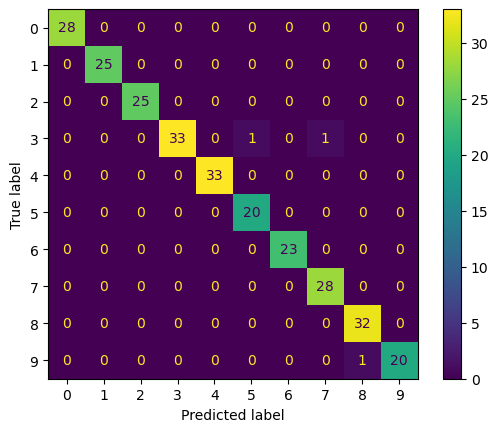

In [18]:
with torch.no_grad():
    outputs = final_model(X_Test_tensor)
    predictions = outputs.argmax(1).numpy() # uložení predikcí
    
# Přesnost
print(f"Testovací přesnost: {100 * accuracy_score(y_Test, predictions):.3f}%")

# Matice záměn
ConfusionMatrixDisplay.from_predictions(y_Test, predictions)
plt.show()

In [19]:
# uložení modelu
torch.save(final_model.state_dict(), "final_model.pt")

V poslední řadě vykresluji ukázku predikce náhodně zvolených číslic testovací množiny.

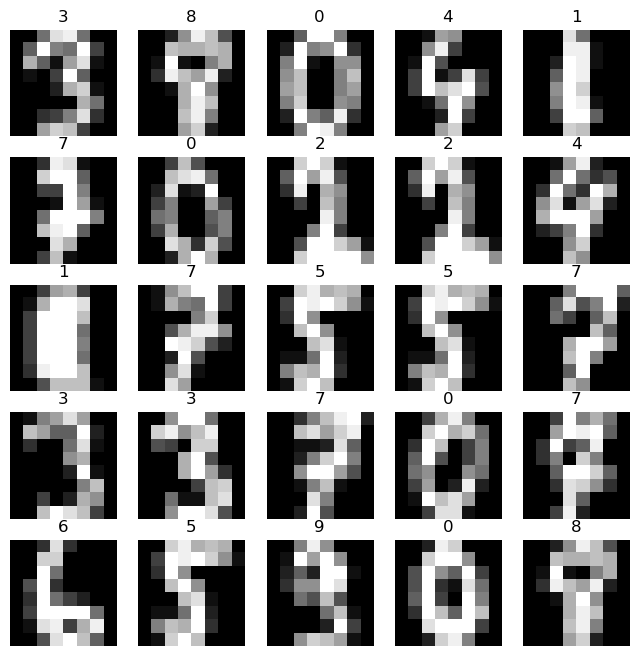

In [20]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    rand_pos = random.randrange(0, len(X_Test_tensor))
    img = X_Test_tensor[rand_pos]
    label = predictions[rand_pos]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img[0,:,:], cmap="gray")
plt.show()